# Importing the stuff

In [1]:
import pandas as pd
import matplotlib.pyplot as plt, matplotlib.image as mpimg

%matplotlib inline

In [2]:
raw = pd.read_csv('input/train.csv')

# Training data is s.t. each entry (row) represents an image. 1 label column, + 784 pixel values.

raw.head(5);

In [3]:
# Training data is 42000 images. That's a lot. We will have to select a subset randomly using pandas' sample().
raw.shape

(42000, 785)

In [4]:
SIZE = 42000
p = 0.85

train = raw.sample(n=SIZE,         # default behaviour is s.t. no one row is sampled twice. 
                   random_state=1) # random_state ensure reproducibility
train = train.reset_index()
train.drop(['index'], axis=1, inplace=True)

In [5]:
train;

In [6]:
# Just to confirm that the values of each pixel can vary from 0 to 255
train.iloc[1].unique()

array([  5,   0,  93, 155,  80,  89, 248, 145,   2,  11, 173, 254, 183,
       195, 253, 209,   6,  13, 218, 211, 189, 125, 184, 194,  12,  96,
       207,  59, 128, 249, 212,  47,  63, 223, 143,  33, 243, 177, 140,
       113, 168,  15, 235, 216, 204, 124, 105, 231, 229, 101, 149,  95,
       174, 240,  31, 116,  99, 122,  90,  45, 226, 238,  25,  20,   3,
         8, 180, 224,  69, 232,  50, 245,  56,  41, 252, 120, 236, 178,
        91, 228, 164, 110, 217, 123,  26, 205, 156,  73], dtype=int64)

# Extract the y out

In [7]:
y = train['label']
y;

In [8]:
train.drop(['label'], axis=1, inplace=True)

# Normalisation

In [9]:
train = train / 255
train;

In [10]:
# Normalised to [0,1]

train.iloc[1].unique();

# Split dataset to train and test sets

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, y, train_size=p, random_state=0)

In [12]:
X_train.shape

(35700, 784)

# Data Augmentation

Generally speaking, you would use Data Augmentation to **expand** on your dataset. If you have a lot to begin with, then this is quite pointless?

In [13]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.10, # Randomly zoom image 
            width_shift_range=0.08,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.08,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False)  # randomly flip images


# Note this does not perform a transformation inplace. You have to 'flow' it out.
X_train_3d = X_train.values.reshape(-1, 28, 28, 1) # '1' is for greyscale channel. If RGB, then '3'.
datagen.fit(X_train_3d) 

Using TensorFlow backend.


For the data augmentation, I choosed to :

- Randomly rotate some training images by 10 degrees
- Randomly Zoom by 10% some training images
- Randomly shift images horizontally by 10% of the width
- Randomly shift images vertically by 10% of the height
- I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset.

# Viewing an Image
- Since the image is currently one-dimension, we load it into a [numpy array][1] and [reshape][2] it so that it is two-dimensional (28x28 pixels)
- Then, we plot the image and label with matplotlib


  [1]: https://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html
  [2]: https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html

In [14]:
img = X_train.iloc[0].values.reshape(28,28) 
img;

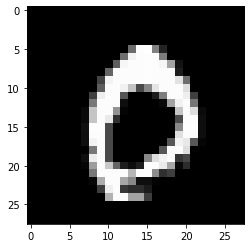

In [15]:
g = plt.imshow(img, 
               cmap='gray')

# Training (Takes a lot of time!)

## Modelling (On Purely Non-augmented Data)

In [16]:
from sklearn import svm

clf = svm.SVC(verbose=True)
clf.fit(X_train, y_train.values)
clf.score(X_test, y_test)

[LibSVM]

0.9747619047619047

## Modelling (On Purely Augmented Data)

In [17]:
np_iter = datagen.flow(x=X_train_3d, y=None, batch_size=int(SIZE*p), shuffle=False)

In [18]:
len(np_iter)

1

In [19]:
X_train_augmented = np_iter.next()

In [20]:
X_train_augmented = X_train_augmented.reshape(-1, 784)

In [21]:
to_execute = True

if to_execute:
    clfa = svm.SVC(verbose=True)
    clfa.fit(X_train_augmented, y_train.values)
    print(clfa.score(X_test, y_test))

[LibSVM]

0.9736507936507937

# Saving Our Models

In [23]:
from joblib import dump, load
dump(clf, 'clf.joblib') 
dump(clfa, 'clfa.joblib') 

['clfa.joblib']

# Predict Test Data

## Load Test Data and Normalize it

In [49]:
test = pd.read_csv('input/test.csv')

In [50]:
test.shape

(28000, 784)

In [51]:
test = test / 255

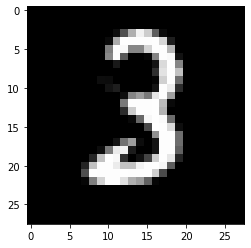

In [52]:
img = test.iloc[4].values.reshape(28,28) 
g = plt.imshow(img, 
               cmap='gray')


In [55]:
prediction = clf.predict(test)

In [56]:
prediction_a = clfa.predict(test)

In [57]:
df = pd.DataFrame(prediction)

## Format for Submission

### For The Unaugmented

In [65]:
df;

In [67]:
df.index.name='ImageId'
df;

In [62]:
df.index+=1
df.columns=['Label']
df

,Label
ImageId,
1,2
2,0
3,9
4,9
5,3
...,...
27996,9
27997,7
27998,3


### For the Augmented

In [64]:
df_a = pd.DataFrame(prediction_a)
df_a.index.name='ImageId'
df_a.index+=1
df_a.columns=['Label']
df_a

,Label
ImageId,
1,2
2,0
3,9
4,9
5,3
...,...
27996,9
27997,7
27998,3


## Save into csv files

In [69]:
df.to_csv('output/pred.csv', header=True)
df_a.to_csv('output/pred_a.csv', header=True)